## Dataset #1 (CDC Diabetes Health Indicators)

### Data Load and Exploration

In [1]:
from ucimlrepo import fetch_ucirepo

# Fetch dataset
cdc_diabetes_healthcare_indicators = fetch_ucirepo(id=891)

# Data (as pandas df)
X = cdc_diabetes_healthcare_indicators.data.features
y = cdc_diabetes_healthcare_indicators.data.targets

# Variable information
print(cdc_diabetes_healthcare_indicators.variables)

                    name     role     type      demographic  \
0                     ID       ID  Integer             None   
1        Diabetes_binary   Target   Binary             None   
2                 HighBP  Feature   Binary             None   
3               HighChol  Feature   Binary             None   
4              CholCheck  Feature   Binary             None   
5                    BMI  Feature  Integer             None   
6                 Smoker  Feature   Binary             None   
7                 Stroke  Feature   Binary             None   
8   HeartDiseaseorAttack  Feature   Binary             None   
9           PhysActivity  Feature   Binary             None   
10                Fruits  Feature   Binary             None   
11               Veggies  Feature   Binary             None   
12     HvyAlcoholConsump  Feature   Binary             None   
13         AnyHealthcare  Feature   Binary             None   
14           NoDocbcCost  Feature   Binary             

In [2]:
X.shape

(253680, 21)

In [3]:
X.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [4]:
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


In [5]:
y.head()

,Diabetes_binary
0,0
1,0
2,0
3,0
4,0


#### Checking for null values

In [6]:
X.isna().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

#### Checking for Class Imbalance

In [7]:
class_counts = y.value_counts()
print(class_counts)

imbalance_ratio = class_counts.max() / class_counts.min()

print(f'Imbalance ratio: {round(imbalance_ratio,2)}')

Diabetes_binary
0                  218334
1                   35346
Name: count, dtype: int64
Imbalance ratio: 6.18


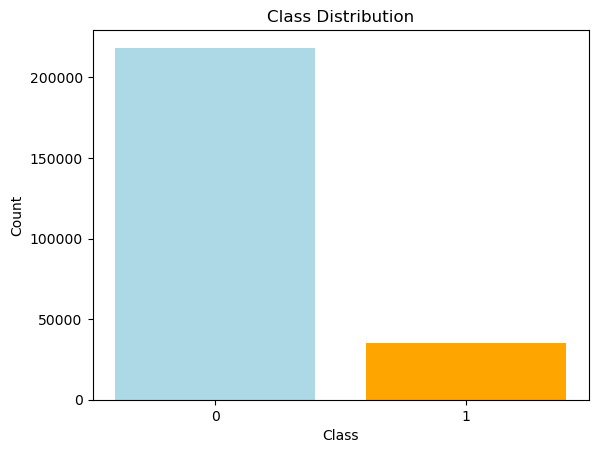

In [8]:
import matplotlib.pyplot as plt

class_labels = [label[0] for label in class_counts.index]
colors = ["lightblue", "orange"]

plt.bar(class_labels, class_counts.values, color=colors)

plt.xticks(range(min(class_labels), max(class_labels) + 1))

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.show()

### Splitting the Data

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Data Processing

#### Random UnderSampling

In [10]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

res_class_counts = y_train_res.value_counts()
print(res_class_counts)

res_imbalance_ratio = res_class_counts.max() / res_class_counts.min()

print(f'Imbalance ratio: {round(res_imbalance_ratio,2)}')

Diabetes_binary
0                  28135
1                  28135
Name: count, dtype: int64
Imbalance ratio: 1.0


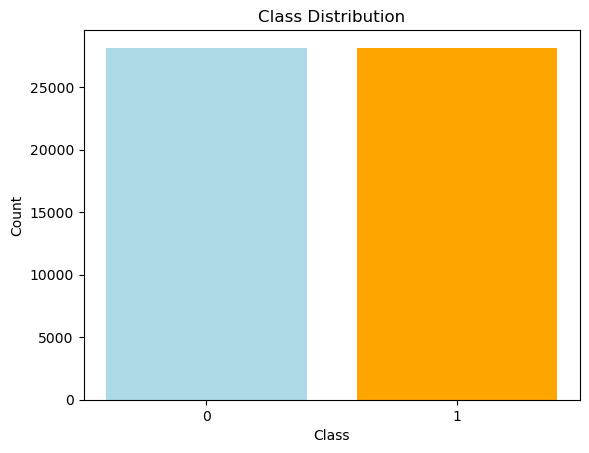

In [11]:
res_class_labels = [label[0] for label in res_class_counts.index]
colors = ["lightblue", "orange"]

plt.bar(res_class_labels, res_class_counts.values, color=colors)

plt.xticks(range(min(res_class_labels), max(res_class_labels) + 1))

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.show()

In [12]:
X_train_res.shape[0] 

56270

#### Data Pipeline

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


numeric_features = ["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age", "Education", "Income"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### Model Building and Training

#### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

logreg.fit(X_train_res, y_train_res)

c:\Users\TRU\miniforge3\envs\dasc_5410\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BMI', 'GenHlth', 'MentHlth',
                                                   'PhysHlth', 'Age',
                                                   'Education', 'Income']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'DiffWalk',
                                                   'Sex'])])),
                ('classifier', LogisticRegression())])

In [15]:
print("LogRegression score: %.3f" % logreg.score(X_test, y_test))

LogRegression score: 0.732


In [16]:

from sklearn.metrics import confusion_matrix, classification_report

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43525
           1       0.32      0.77      0.45      7211

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.64     50736
weighted avg       0.86      0.73      0.77     50736



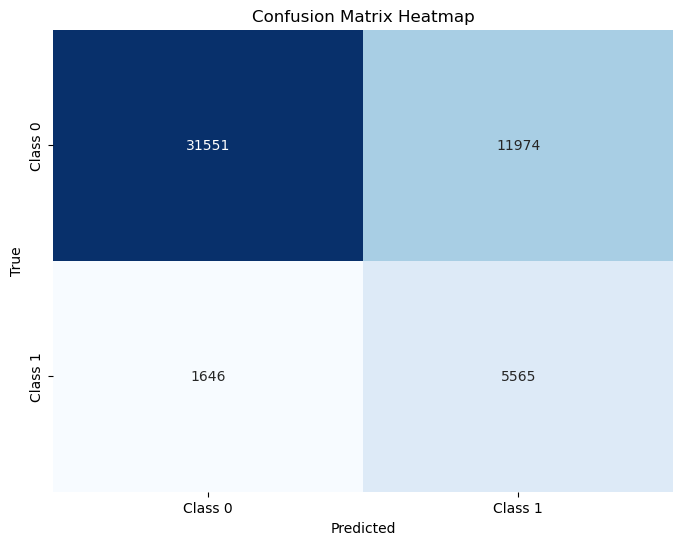

In [17]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Dataset #2 (Diabetes)

### Data Load and Exploration

In [18]:
import pandas as pd

X = pd.read_csv('data/diabetes.csv')

In [19]:
X.shape

(768, 13)

In [20]:
X.head()

,Pregnancies,Gender,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,CalorieIntake,Exercise,SleepDuration
0,0,M,148,72,35,0,33.6,0.627,50,1,2508.3,No,6
1,1,F,85,66,29,0,26.6,0.351,31,0,2760.0,Evening,8
2,0,M,183,64,0,0,23.3,0.672,32,1,6480.0,Morning,8
3,1,F,89,66,23,94,28.1,0.167,21,0,NaN,Evening,8
4,0,M,137,40,35,168,43.1,2.288,33,1,1970.0,No,9


In [21]:
X.columns

Index(['Pregnancies', 'Gender', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'CalorieIntake', 'Exercise', 'SleepDuration'],
      dtype='object')

In [22]:
y = X.Outcome
X = X.drop("Outcome", axis="columns")

#### Checking for null values

In [23]:
X.isna().sum()

Pregnancies                  0
Gender                       0
Glucose                      0
BloodPressure                0
SkinThickness                0
Insulin                      0
BMI                          0
DiabetesPedigreeFunction     0
Age                          0
CalorieIntake               15
Exercise                     0
SleepDuration                0
dtype: int64

#### Checking for Class Imbalance

In [24]:
class_counts = y.value_counts()
print(class_counts)

imbalance_ratio = class_counts.max() / class_counts.min()

print(f'Imbalance ratio: {round(imbalance_ratio,2)}')

Outcome
0    500
1    268
Name: count, dtype: int64
Imbalance ratio: 1.87


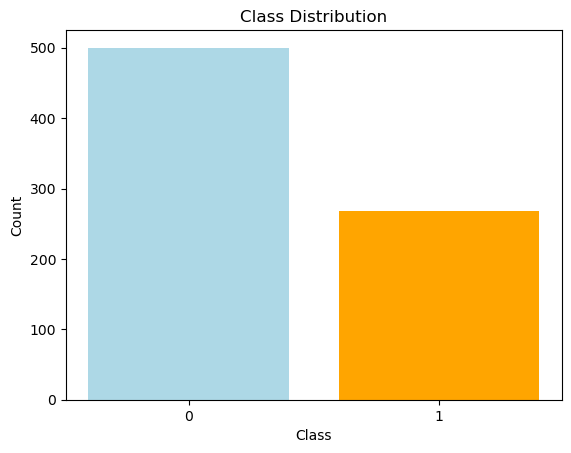

In [25]:
colors = ["lightblue", "orange"]

plt.bar(class_counts.index, class_counts.values, color=colors)

plt.xticks(range(min(class_labels), max(class_labels) + 1))

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.show()

### Splitting the Data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Data Processing

#### Processing null values

In [27]:
X_train.isna().sum()

Pregnancies                  0
Gender                       0
Glucose                      0
BloodPressure                0
SkinThickness                0
Insulin                      0
BMI                          0
DiabetesPedigreeFunction     0
Age                          0
CalorieIntake               11
Exercise                     0
SleepDuration                0
dtype: int64

In [28]:
X_train.dropna()

,Pregnancies,Gender,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,CalorieIntake,Exercise,SleepDuration
603,0,M,150,78,29,126,35.2,0.692,54,7070.0,No,7
118,4,F,97,60,23,0,28.2,0.443,22,2733.0,Evening,5
247,0,F,165,90,33,680,52.3,0.427,23,3733.0,Evening,5
157,1,F,109,56,21,135,25.2,0.833,23,2620.0,Morning,8
468,0,M,120,0,0,0,30.0,0.183,38,4280.0,No,8
...,...,...,...,...,...,...,...,...,...,...,...,...
763,3,F,101,76,48,180,32.9,0.171,63,2860.0,Morning,6
192,0,M,159,66,0,0,30.4,0.383,36,2500.2,No,7
629,4,F,94,65,22,0,24.7,0.148,21,2760.0,Morning,5
559,3,F,85,74,0,0,30.1,0.300,35,2760.0,Morning,6


### Model Building and Training

#### Logistic Regression

In [29]:
numeric_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
       'CalorieIntake', 'SleepDuration']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["Gender", "Exercise"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [30]:
logreg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age', 'CalorieIntake',
                                                   'SleepDuration']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Exercise'])])),
                ('classifier', LogisticRegression())])

In [31]:
print("LogRegression score: %.3f" % logreg.score(X_test, y_test))

LogRegression score: 0.968


In [32]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       107
           1       0.96      0.94      0.95        47

    accuracy                           0.97       154
   macro avg       0.96      0.96      0.96       154
weighted avg       0.97      0.97      0.97       154



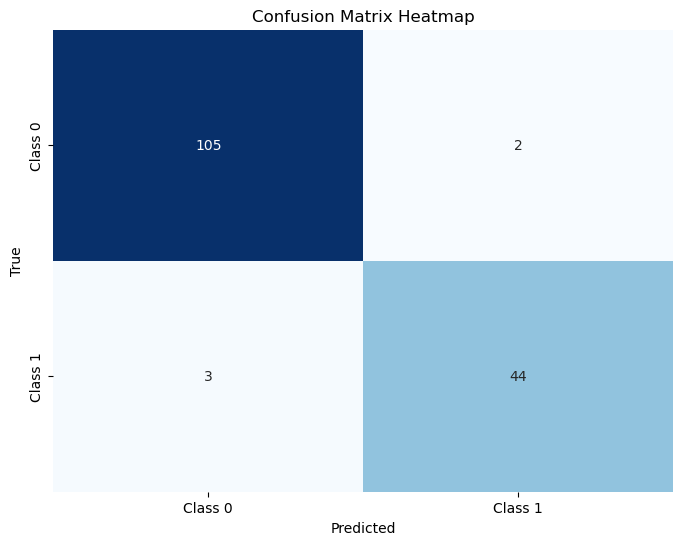

In [33]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Dataset #3 (Comprehensive Diabetes Clinical Dataset)

### Data Load and Exploration

In [34]:
X = pd.read_csv('data/diabetes_3.csv')

In [35]:
X.shape

(100000, 16)

In [36]:
X.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [37]:
X.columns

Index(['year', 'gender', 'age', 'location', 'race:AfricanAmerican',
       'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other',
       'hypertension', 'heart_disease', 'smoking_history', 'bmi',
       'hbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [38]:
y = X.diabetes
X = X.drop("diabetes", axis="columns")

#### Checking for null values

In [39]:
X.isna().sum()

year                    0
gender                  0
age                     0
location                0
race:AfricanAmerican    0
race:Asian              0
race:Caucasian          0
race:Hispanic           0
race:Other              0
hypertension            0
heart_disease           0
smoking_history         0
bmi                     0
hbA1c_level             0
blood_glucose_level     0
dtype: int64

#### Checking for Class Imbalance

In [40]:
class_counts = y.value_counts()
print(class_counts)

imbalance_ratio = class_counts.max() / class_counts.min()

print(f'Imbalance ratio: {round(imbalance_ratio,2)}')

diabetes
0    91500
1     8500
Name: count, dtype: int64
Imbalance ratio: 10.76


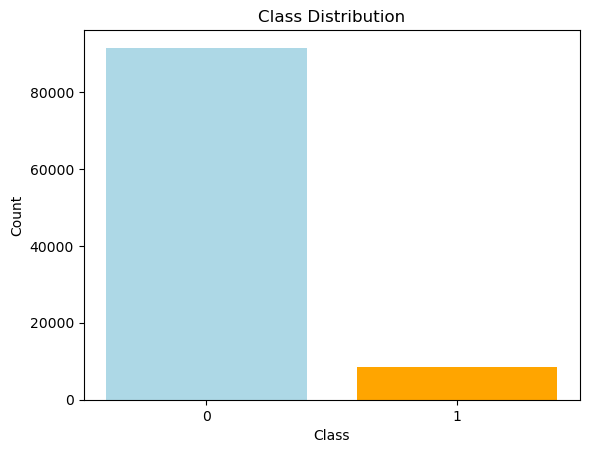

In [41]:
colors = ["lightblue", "orange"]

plt.bar(class_counts.index, class_counts.values, color=colors)

plt.xticks(range(min(class_labels), max(class_labels) + 1))

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.show()

### Splitting the Data

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Data Processing

#### Random UnderSampling

In [43]:
rus = RandomUnderSampler(sampling_strategy=1)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

res_class_counts = y_train_res.value_counts()
print(res_class_counts)

res_imbalance_ratio = res_class_counts.max() / res_class_counts.min()

print(f'Imbalance ratio: {round(res_imbalance_ratio,2)}')

diabetes
0    6794
1    6794
Name: count, dtype: int64
Imbalance ratio: 1.0


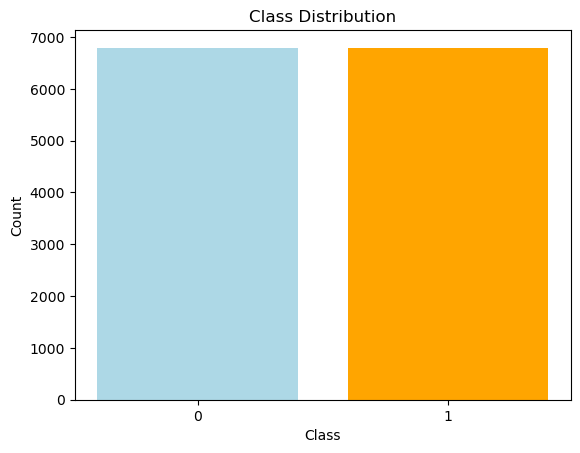

In [44]:
colors = ["lightblue", "orange"]

plt.bar(res_class_counts.index, res_class_counts.values, color=colors)

plt.xticks(range(min(res_class_labels), max(res_class_labels) + 1))

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.show()

### Model Building and Training

#### Logistic Regression

In [45]:
numeric_features = ['year', 'age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ['gender', 'location', 'race:AfricanAmerican',
       'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other',
       'hypertension', 'heart_disease', 'smoking_history']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [46]:
logreg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'age', 'bmi',
                                                   'hbA1c_level',
                                                   'blood_glucose_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'location',
                                                   'race:AfricanAmerican',
                                                   'race:Asian',
                                                   'race:Caucasian',
                                                   'race:Hispanic',
                                                   'race:Other', 'hypertension',
                                                   'heart_disease',
                                                   'smoking_history'])])),
                ('classifier', LogisticRegression())])

In [47]:
print("LogRegression score: %.3f" % logreg.score(X_test, y_test))

LogRegression score: 0.961


In [48]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18294
           1       0.86      0.64      0.73      1706

    accuracy                           0.96     20000
   macro avg       0.92      0.81      0.86     20000
weighted avg       0.96      0.96      0.96     20000



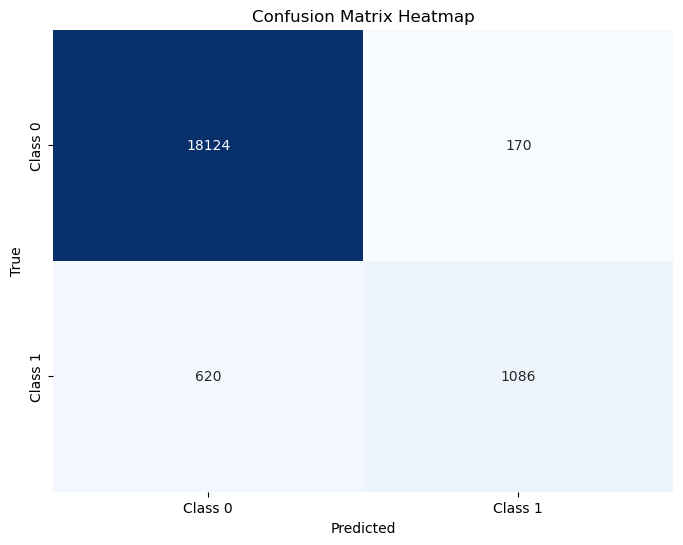

In [49]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Dataset #4 (Early Stage Diabetes Risk Prediction)

### Data Load and Exploration

In [50]:
X = pd.read_csv('data/diabetes_4.csv')

In [51]:
X.shape

(520, 17)

In [52]:
X.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [53]:
X.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [57]:
X = X.rename(columns={'class': 'diabetes'})
X.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,diabetes
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [59]:
y = X.diabetes
X = X.drop('diabetes', axis="columns")

#### Checking for null values

In [60]:
X.isna().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
dtype: int64

#### Checking for Class Imbalance

In [61]:
class_counts = y.value_counts()
print(class_counts)

imbalance_ratio = class_counts.max() / class_counts.min()

print(f'Imbalance ratio: {round(imbalance_ratio,2)}')

diabetes
Positive    320
Negative    200
Name: count, dtype: int64
Imbalance ratio: 1.6


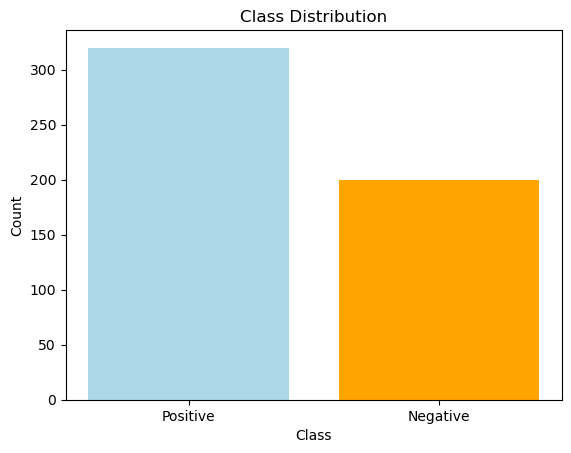

In [62]:
colors = ["lightblue", "orange"]

plt.bar(class_counts.index, class_counts.values, color=colors)

plt.xticks(range(min(class_labels), max(class_labels) + 1))

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.show()

### Splitting the Data

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Model Building and Training

#### Logistic Regression

In [64]:
numeric_features = ['Age']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [65]:
logreg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Polyuria',
                                                   'Polydipsia',
                                                   'sudden weight loss',
                                                   'weakness', 'Polyphagia',
                                                   'Genital thrush',
                                                   'visual blurring', 'Itching',
                                                   'Irritability',
                                                   'delayed healing',
                                                   'partial paresis',
                                                   'muscle stiffness',
                                                   'Alopecia', 'Obesity'])])),
                ('classifier', LogisticRegression())])

In [66]:
print("LogRegression score: %.3f" % logreg.score(X_test, y_test))

LogRegression score: 0.952


In [67]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94        40
    Positive       0.95      0.97      0.96        64

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104



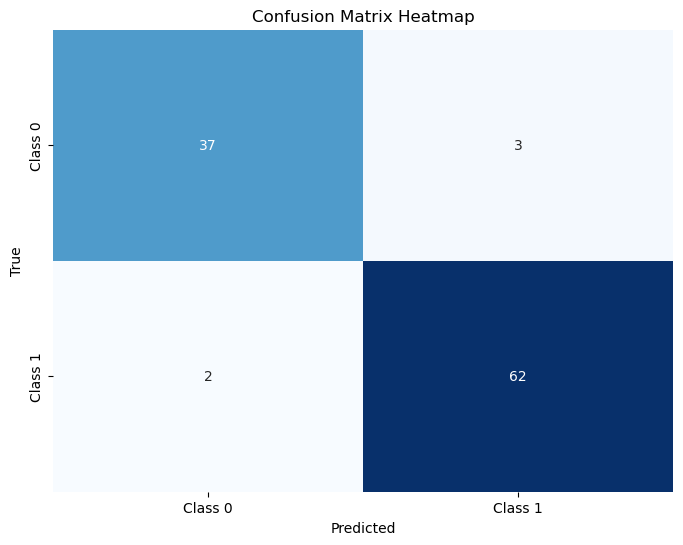

In [68]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()